<a href="https://colab.research.google.com/github/aj2622/Computational-CogSci/blob/master/Bayesian_modeling_Number_Game.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bayesian concept learning with the number game


In [0]:
from __future__ import print_function
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import random
import numpy as np
from scipy.special import logsumexp

x_max = 100 # maximum number allowed
x_all = np.arange(0,x_max+1)

In [3]:
def make_h_odd():
    return list(range(1,x_max+1,2))

def make_h_even():
    return list(range(2,x_max+1,2))

def make_h_square():
    h = []
    for x in range(1,x_max+1):
        if x**2 <= x_max:
            h.append(x**2)
    return h

def make_h_cube():
    h = []
    for x in range(1,x_max+1):
        if x**3 <= x_max:
            h.append(x**3)
    return h

def make_h_primes():
    return [2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47, 53, 59, 61, 67, 71, 73, 79, 83, 89, 97]

def make_h_mult_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if x*y <= x_max:
            h.append(x*y)
    return h

def make_h_powers_of_y(y):
    h = []
    for x in range(1,x_max+1):
        if y**x <= x_max:
            h.append(y**x)
    return h

def make_h_numbers_ending_in_y(y):
    h = []
    for x in range(1,x_max+1):
        if str(x)[-1] == str(y):
            h.append(x)
    return h

def generate_math_hypotheses(mylambda):
    h_set = [make_h_odd(), make_h_even(), make_h_square(), make_h_cube(), make_h_primes()]
    h_set += [make_h_mult_of_y(y) for y in range(3,13)]
    h_set += [make_h_powers_of_y(y) for y in range(2,11)]
    h_set += [make_h_numbers_ending_in_y(y) for y in range(0,10)]
    n_hyp = len(h_set)
    log_prior = np.log(mylambda * np.ones(n_hyp) / float(n_hyp))
    return h_set, log_prior

h_set_math, log_prior_math = generate_math_hypotheses(2./3)
print("Four examples of math hypotheses:")
for i in range(4):
    print(h_set_math[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_math[0:4])

Four examples of math hypotheses:
[1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39, 41, 43, 45, 47, 49, 51, 53, 55, 57, 59, 61, 63, 65, 67, 69, 71, 73, 75, 77, 79, 81, 83, 85, 87, 89, 91, 93, 95, 97, 99]

[2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 52, 54, 56, 58, 60, 62, 64, 66, 68, 70, 72, 74, 76, 78, 80, 82, 84, 86, 88, 90, 92, 94, 96, 98, 100]

[1, 4, 9, 16, 25, 36, 49, 64, 81, 100]

[1, 8, 27, 64]

Their prior log-probabilities:
[-3.93182563 -3.93182563 -3.93182563 -3.93182563]


In [4]:
def make_h_between_y_and_z(y,z):
    assert(y >= 1 and z <= x_max)
    return list(range(y,z+1))

def pdf_erlang(x,sigma=10.):
    return (x / sigma**2) * np.exp(-x/sigma)

def generate_interval_hypotheses(mylambda):
    h_set = []
    for y in range(1,x_max+1):
        for z in range(y,x_max+1):            
            h_set.append(make_h_between_y_and_z(y,z))
    nh = len(h_set)
    pv = np.ones(nh)
    for idx,h in enumerate(h_set): # prior based on length
        pv[idx] = pdf_erlang(len(h))
    pv = pv / np.sum(pv)
    pv = (1-mylambda) * pv
    log_prior = np.log(pv)
    return h_set, log_prior

h_set_int, log_prior_int = generate_interval_hypotheses(2./3)
print("Four examples of interval hypotheses")
for i in range(4):
    print(h_set_int[i])
    print("")
print("Their prior log-probabilities:")
print(log_prior_int[0:4])

Four examples of interval hypotheses
[1]

[1, 2]

[1, 2, 3]

[1, 2, 3, 4]

Their prior log-probabilities:
[-10.197254    -9.60410682  -9.29864171  -9.11095964]


In [5]:
def convert_h_list_to_numpy(h_list):
    h_numpy = np.zeros(x_all.size)
    h_numpy[np.array(h_list)] = 1
    return h_numpy

def generate_hypotheses(mylambda):
    h_math,lp_math = generate_math_hypotheses(mylambda)
    h_interval,lp_interval = generate_interval_hypotheses(mylambda)
    H = h_math + h_interval
    H_numpy = [convert_h_list_to_numpy(h) for h in H]
    log_prior = np.concatenate((lp_math,lp_interval))
    assert(np.isclose(np.sum(np.exp(log_prior)),1.0))
    return H_numpy,log_prior

print("Example of converting list hypothesis to numpy array...")
print("original hypothesis:")
h_list = [2,4,6]
print(h_list)
h_numpy = convert_h_list_to_numpy(h_list)
print("converted numpy array:")
print(h_numpy[0:10])

Example of converting list hypothesis to numpy array...
original hypothesis:
[2, 4, 6]
converted numpy array:
[0. 0. 1. 0. 1. 0. 1. 0. 0. 0.]


In [0]:
def log_posterior(data,list_hypothesis,log_prior):
    # INPUT
    #  data : python list of observed numbers (X) 
    #  list_hypothesis : [nh length list] each hypothesis is a binary numpy array 
    #  log_prior : numpy vector [length nh] (log prior value for each hypothesis)
    data_numpy = convert_h_list_to_numpy(data) # length nh numpy vector
    nh = len(list_hypothesis)
    ll = np.zeros(nh)
    for idx,h in enumerate(list_hypothesis):
        ll[idx] = log_likelihood(data_numpy,h)
    lpost = ll + log_prior
    lpost = lpost - logsumexp(lpost)
    return lpost

In [0]:
def log_likelihood(data_numpy, hypothesis):
    # INPUT
    #  data_numpy : size x_max binary numpy array (observed numbers)
    #  hypothesis: size x_max binary numpy array (included numbers in single hypothesis)
    # RETURN
    #  ll : log-likelihood value (REMEMBER TO CONVERT TO NATURAL LOG (np.log()))
    assert(hypothesis.size == data_numpy.size)
    n_d = np.sum(data_numpy)
    n_h = np.sum(hypothesis)

    # TODO: Add your code to check whether or not the hypothesis contains all of the data.
    #   If it does not, return -np.inf (log(0))
    test_cond = hypothesis - data_numpy
    for h in test_cond:
        if -1 == h:
            return -np.inf
    # TODO: Add your code to compute the log-likelihood if the hypothesis contains all of the data.
    ll = 1
    for h in data_numpy:
        if h == 1:
            ll = ll * (1/n_h)
    ll = np.log(ll)
    return ll

In [0]:
def bayesian_predictions(data_eval, data, list_hypothesis, log_prior):
    # INPUT
    #  data_eval : [length ne python list] of new numbers we want to check the probability of membership for
    #     each number in data_eval is to be evaluated independently -- it's a separate 'y' in equation above
    #  data : [python list] observed numbers (X) 
    #  list_hypothesis : python list of hypotheses, each is a binary numpy array 
    #  log_prior : numpy vector [length nh] which is the log prior value for each hypothesis
    # 
    # RETURN
    #  pp : numpy vector [size ne] of predicted probabilities of new numbers in data_eval (NOTE: NOT IN LOG SPACE)
    lpost = log_posterior(data,list_hypothesis,log_prior)
    post = np.exp(lpost) # posterior probabilities
    h_mat = np.array(list_hypothesis) # create a [nh by x_max] numpy matrix, showing numbers in each hypothesis
    ne = len(data_eval) # how many numbers to evaluate
    pp = np.zeros(ne) # predicted probability of each number
    for idx,de in enumerate(data_eval):
        #TODO : Add your code here to compute predicted probabilities. Can be a single line with form "pp[idx] = "..
        pp[idx] = np.sum([(h[de]) for h in list_hypothesis] * post)
    return pp

# TODO : Check your answers for problem 2 using the bayesian_prediction function

In [0]:
def plot_predictions(x_eval,mypred):
    mybottom = -0.1
    plt.figure(figsize=(10, 2))
    plt.bar(x_eval,mypred-mybottom,bottom=mybottom)
    plt.ylim((mybottom,1.2))
    plt.xticks(np.arange(0, x_max+1, step=4))
    plt.yticks([0,0.5,1])

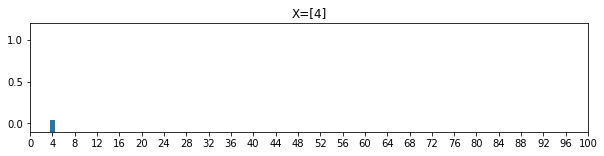

[0.03846154]


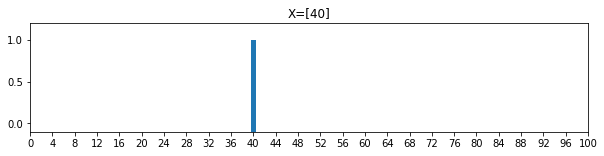

[1.]


In [11]:
h_test = [make_h_even()]
h_test += [make_h_numbers_ending_in_y(0)]

log_prior_test = np.array([np.log(0.5), np.log(0.5)])

H_numpy_test = [convert_h_list_to_numpy(h) for h in h_test]

mypred = bayesian_predictions([4], [10,30], H_numpy_test, log_prior_test)
plot_predictions([4],mypred)
plt.title('X=[4]')
plt.show()
print(mypred)

mypred = bayesian_predictions([40], [10,30], H_numpy_test, log_prior_test)
plot_predictions([40],mypred)
plt.title('X=[40]')
plt.show()
print(mypred)

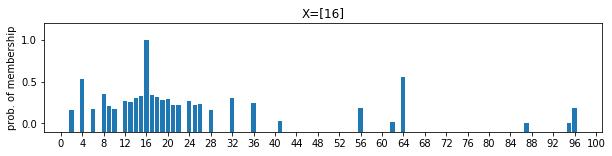

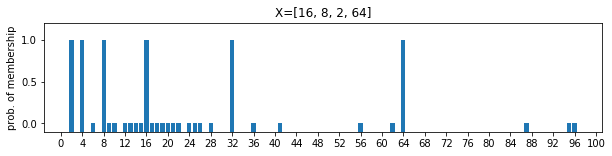

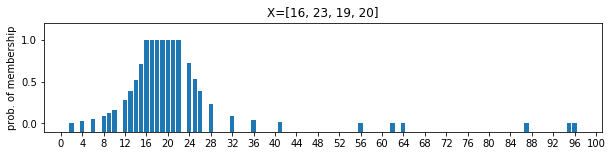

In [12]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.4)
x_eval = [2,4,6,8,9,10]+list(range(12,23))+[24,25,26,28,32,36,41,56,62,64,87,95,96]

mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 8, 2, 64]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 23, 19, 20]')
plt.ylabel('prob. of membership')
plt.show()

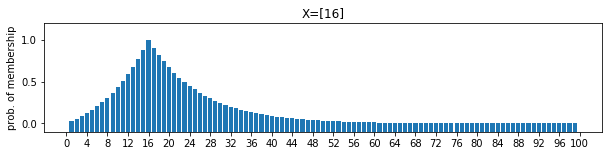

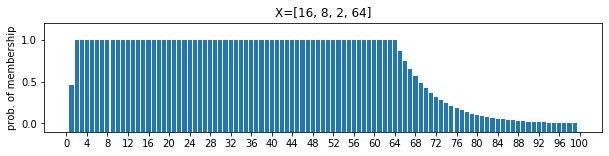

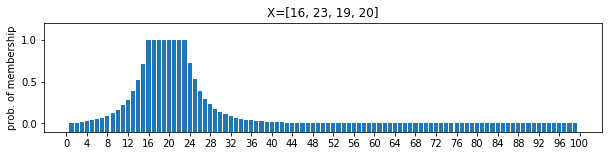

In [13]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.0000000001)
x_eval = list(range(1,100))
mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 8, 2, 64]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 23, 19, 20]')
plt.ylabel('prob. of membership')
plt.show()

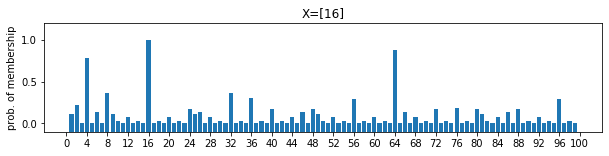

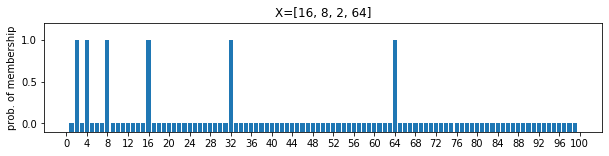

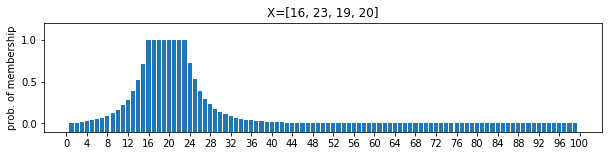

In [14]:
H_all,log_prior_all = generate_hypotheses(mylambda=0.9999999999999999)
x_eval = list(range(1,100))
mypred = bayesian_predictions(x_eval, [16], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 8, 2, 64], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 8, 2, 64]')
plt.ylabel('prob. of membership')
mypred = bayesian_predictions(x_eval, [16, 23, 19, 20], H_all, log_prior_all)
plot_predictions(x_eval,mypred)
plt.title('X=[16, 23, 19, 20]')
plt.ylabel('prob. of membership')
plt.show()